David's version of 02_production, trained with Miatas instead of bears.

## Setup

In [1]:
import os
if os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] != "1":
    raise Exception("PYTORCH_ENABLE_MPS_FALLBACK needs to be set to 1 to prevent some issues down this notebook")

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Fetch the images and remove invalid ones

In [3]:
mx5_types = ('NA', 'NB', 'NC', 'ND')
path = Path('mx5')

In [10]:
if not path.exists():
    path.mkdir()
    for o in mx5_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'mazda miata {o}')
        download_images(dest, urls=results)

In [ ]:
failed = verify_images(get_image_files(path))
failed

(#52) [Path('mx5/NA/5b17a195-a11a-484c-92ed-23b78441b23b.jpg'),Path('mx5/NA/b4d5684f-d1e3-4a08-8493-e7eb33b74172.jpg'),Path('mx5/NA/24667e04-7634-4f65-b418-79d6bf5e1634.jpg'),Path('mx5/NA/475b8673-28f3-4a71-a834-37f99e09f7ba.png'),Path('mx5/NA/82302724-a8a5-4657-bf53-76913e4a8aa5.jpg'),Path('mx5/NA/2515ceea-d649-4377-8604-71a5d768af2e.jpg'),Path('mx5/NA/f4a950df-80ea-4dd4-9bf8-7d53b6ecf1bb.jpg'),Path('mx5/NA/644812fd-1927-40f9-aa33-016d19988762.jpg'),Path('mx5/NA/0c675b6c-17c4-4243-bfd8-6c6b94f52ed2.jpg'),Path('mx5/NA/4d54e434-8038-46ec-9f72-959b8ba298fc.jpeg'),Path('mx5/NA/c9e0ea71-9eff-464e-a4df-b8456c0dd291.jpg'),Path('mx5/NA/0639e283-45a1-4204-bc5a-3f358cc8acc3.jpg'),Path('mx5/NC/c5014882-73b6-443d-aac8-5c5635f5dd06.jpg'),Path('mx5/NC/c4e6cdf8-ec96-411d-bd91-84cf068230b8.jpg'),Path('mx5/NC/30c72f1f-540d-472d-835c-7d942185dac2.jpg'),Path('mx5/NC/3af6f5a9-3b66-42f9-a658-ad2850c26916.jpg'),Path('mx5/NC/204406fa-a569-4c9e-b2b5-b168fac1ebd9.jpg'),Path('mx5/NC/f7e7ac48-513e-429d-b99c-03f

In [12]:
failed.map(Path.unlink);

## Prepare the training data

### Make a DataBlock

In [13]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

### Peek at the data

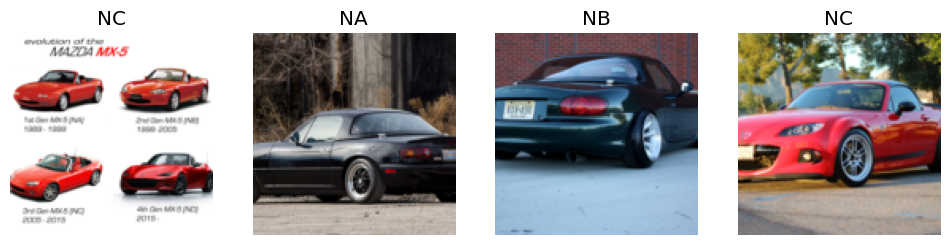

In [14]:
dls = cars.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Augment the data and peek at it again

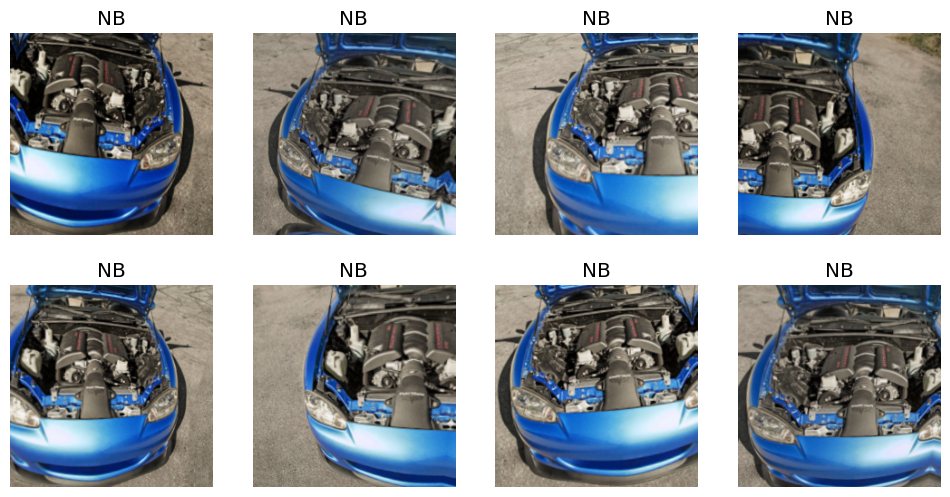

In [ ]:
augmented = cars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = augmented.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Train the model

In [72]:
dls = cars.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.261702,1.646577,0.575758,00:21


epoch,train_loss,valid_loss,error_rate,time
0,1.619266,1.216156,0.469697,00:20
1,1.461514,1.105546,0.462121,00:20
2,1.256472,0.920929,0.371212,00:20
3,1.126736,0.879551,0.356061,00:20


### Confusion matrix

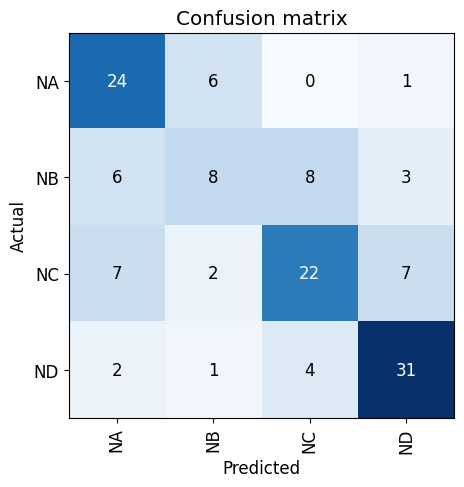

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Display the wrongest predictions

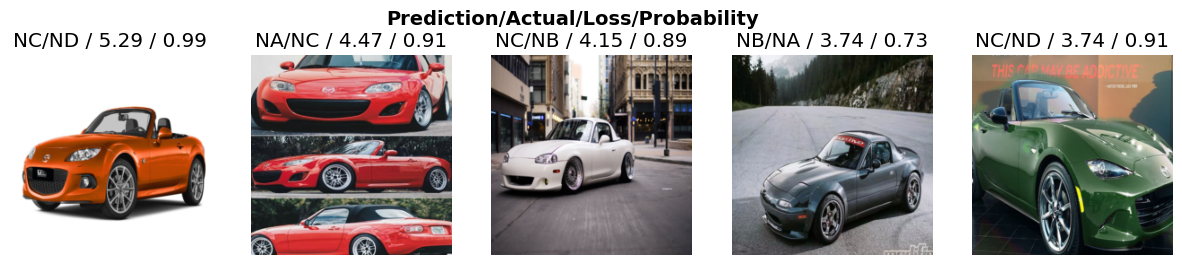

In [74]:
interp.plot_top_losses(5, nrows=1)

### Clean up data based on the wrongest predictions

In [75]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### Apply the changes from the cleaner

In [76]:
import uuid

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
    origin = cleaner.fns[idx]
    destination_dir = path/cat
    shutil.move(str(origin), destination_dir)


## Export the model

In [79]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Import the model

In [78]:
learn_inf = load_learner(path/'export.pkl')

## Create a widget-based app for inference

In [80]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [83]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [84]:
pred,pred_idx,probs = learn_inf.predict(img)

In [85]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: ND; Probability: 0.7560')

In [86]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [89]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    btn_upload.value.clear()

btn_run.on_click(on_click_classify)

In [88]:
VBox([widgets.Label('Select your MX-5!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [93]:
doc(btn_upload)